# Lecture 9 - Graph Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Build basic MLP-style Neural Networks from scratch using **PyTorch**.  
- Explain molecules as **graphs**: atoms = nodes, bonds = edges, features at each.  
- Write the **message passing** equations and understand neighborhood aggregation.  
- Build a tiny GNN in PyTorch on toy molecules.  
- Prepare molecular **graphs from SMILES** and run a mini GNN.  
- Experience with a MPNN example **Chemprop**.  

---

## 1. Setup

We reuse most of the stack from earlier lectures.

In [1]:
# 1. Setup
import warnings, math, os, sys, json, time, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn bits for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)

# Torch for MLP and GNN
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
except Exception as e:
    print("Installing torch, this may take a minute...")
    %pip -q install torch
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader

# RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
        %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

# A small global seed helper
def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed(0)

---




## 2 Building MLP from scratch

In Lecture 8 we built MLPs with `scikit‑learn`. Today we start by doing the same with **PyTorch**. One advantage of using PyTorch is that it lets you write the forward pass directly, control the training loop, and later move to GPUs or custom layers. We start tiny and stay friendly.


We will predict **melting point** from four descriptors: `MolWt`, `LogP`, `TPSA`, `NumRings`, same as before.


### 2.1 PyTorch regression on melting point

Every PyTorch project has three parts:

1. **Model**: stack of layers with weights and activations.  
2. **Loss**: a number telling how far predictions are from the truth.  
3. **Optimizer**: an algorithm that adjusts weights to reduce loss.

We use descriptors `[MolWt, LogP, TPSA, NumRings]` to predict `Melting Point`.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_oxidation_raw = pd.read_csv(url)
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "LogP": None,
            "TPSA": None,
            "NumRings": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                    # molecular weight
        "LogP": Crippen.MolLogP(mol),                       # octanol-water logP
        "TPSA": rdMolDescriptors.CalcTPSA(mol),             # topological polar surface area
        "NumRings": rdMolDescriptors.CalcNumRings(mol)      # number of rings
    })

# Apply the function to the SMILES column
desc_df = df_oxidation_raw["SMILES"].apply(calc_descriptors)

# Concatenate new descriptor columns to original DataFrame
df = pd.concat([df_oxidation_raw, desc_df], axis=1)
df

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,90299-04-0,CC(C)(N)c1ccc2ccccc2c1,0.018990,10.04,toxic,121.5,-1,-1,185.270,3.0336,26.02,2.0
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",128-93-8,CNc1ccc(Br)c2c1C(=O)c1ccccc1C2=O,0.021590,7.81,toxic,154.0,-1,-1,316.154,3.2662,46.17,3.0
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,86636-92-2,C=CC(=O)c1ccc2cc(N(C)C)ccc2c1,0.017866,8.58,toxic,128.3,-1,-1,225.291,3.2745,20.31,2.0
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",34316-15-9,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,0.016210,5.54,toxic,215.6,-1,-1,348.378,3.7166,40.80,5.0


In [3]:
df_reg = df[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
X = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]].values.astype(np.float32)
y = df_reg["Melting Point"].values.astype(np.float32).reshape(-1, 1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_tr)
X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
X_tr[:3], X_tr_s[:3]


(array([[226.703 ,   3.687 ,  26.3   ,   1.    ],
        [282.295 ,   2.5255,  52.6   ,   3.    ],
        [468.722 ,   7.5302,  43.37  ,   5.    ]], dtype=float32),
 array([[ 0.06339765,  0.44967934, -0.24905416, -0.86862624],
        [ 0.6769087 , -0.22752753,  0.58845747,  0.51635844],
        [ 2.7343087 ,  2.6904383 ,  0.2945323 ,  1.9013431 ]],
       dtype=float32))

---

### 2.2 Build a tiny network

Now we will start to build a network has one hidden layer of 32 units with ReLU activation.  
Output is a single number (regression).

This is equivalent to what we did before with:

> MLPRegressor(hidden_layer_sizes=(32,), activation="relu")


But the difference is that in scikit-learn the whole pipeline is hidden inside one class.

In PyTorch we build the pieces ourselves: the layers, the activation, and the forward pass.

This way you can see what is happening under the hood.

**How PyTorch models work**  
- A model is a Python object with **layers**. Each layer has **parameters** (weights and bias).  
- You pass an input **tensor** through the model to get predictions. This call is the **forward pass**.  
- PyTorch **records** operations during the forward pass. That record lets it compute **gradients** during `loss.backward()`.  
- Parameters live in `model.parameters()` and can be saved with `model.state_dict()`.  
- `.to(device)` moves the model to GPU if available. Inputs must be on the same device.

**Two common ways to build a model**  
1) **`nn.Sequential`**: fast for simple stacks.  
2) **Subclass `nn.Module`**: gives you a custom `forward` method and more control.

Below we show both styles. Pick one. They behave the same here.

In [4]:
# Sequential style: quickest for simple feed-forward nets
in_dim = X_tr_s.shape[1]
reg_model = nn.Sequential(
    nn.Linear(in_dim, 32),  # weights W: [in_dim, 32], bias b: [32]
    nn.ReLU(),
    nn.Linear(32, 1)        # weights W: [32, 1], bias b: [1]
)
reg_model 


Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
# Inspect shapes of parameters
for name, p in reg_model.named_parameters():
    print(f"{name:20s}  shape={tuple(p.shape)}  requires_grad={p.requires_grad}")

0.weight              shape=(32, 4)  requires_grad=True
0.bias                shape=(32,)  requires_grad=True
2.weight              shape=(1, 32)  requires_grad=True
2.bias                shape=(1,)  requires_grad=True


A custom module version looks like this:

In [6]:
class TinyRegressor(nn.Module):
    def __init__(self, in_dim, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)  # input -> hidden layer
        self.act = nn.ReLU()  # ReLU activation function in hidden layer
        self.fc2 = nn.Linear(hidden, 1)   # hidden -> output layer
    def forward(self, x):
        # x has shape [batch, in_dim]
        h = self.act(self.fc1(x))  # shape [batch, hidden]
        out = self.fc2(h)          # shape [batch, 1]
        return out

reg_model2 = TinyRegressor(in_dim, hidden=32)
reg_model2

TinyRegressor(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

**Shapes to keep in mind**  
- Input batch `x`: `[batch, in_dim]`  
- Hidden layer output: `[batch, 32]`  
- Final output: `[batch, 1]`

**Tip**: you can print a few predictions to sanity check the flow (numbers will be random before training).

In [7]:
x_sample = torch.from_numpy(X_tr_s[:3])
with torch.no_grad():
    print("Raw outputs using first 3 values on X-train:", reg_model(x_sample).cpu().numpy().ravel())

Raw outputs using first 3 values on X-train: [-0.3615578   0.06239668  0.7558894 ]


For the rest of this chapter, we will use method 2 (`reg_model2`) to show the rest steps.

---

### 2.3 Loss and optimizer

For regression we use **MSELoss**.  
The optimizer is **Adam**, which updates weights smoothly.

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(reg_model2.parameters(), lr=1e-2, weight_decay=1e-3)
optimizer 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)

---

### 2.4 One training step demo

To see the loop clearly: forward → loss → backward → update.

In [9]:
xb = torch.from_numpy(X_tr_s[:64])
yb = torch.from_numpy(y_tr[:64])

pred = reg_model2(xb)      # forward pass
loss = loss_fn(pred, yb)  # compute loss

optimizer.zero_grad()     # clear old grads
loss.backward()           # compute new grads for each parameter
optimizer.step()          # apply the update

float(loss.item())

19706.015625

---

### 2.5 Training loop

We train for 150 epochs. Each epoch goes through the dataset in batches.  
We plot the loss to see if the model is learning.

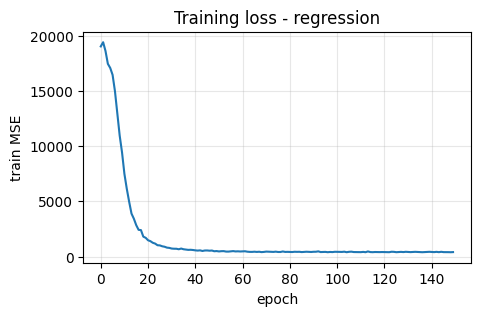

In [10]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(NumpyDataset(X_tr_s, y_tr), batch_size=64, shuffle=True)

train_losses = []
reg_model2.train()
for epoch in range(150):
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb, yb
        pred = reg_model2(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

plt.figure(figsize=(5,3))
plt.plot(train_losses)
plt.xlabel("epoch"); plt.ylabel("train MSE")
plt.title("Training loss - regression")
plt.grid(alpha=0.3)
plt.show()

Let’s break down what happened above step by step:

1. **Dataset and DataLoader**  
   We wrapped our numpy arrays in `NumpyDataset`, which makes them look like a PyTorch dataset.  
   Then `DataLoader` split the dataset into mini-batches of 64 rows and shuffled them each epoch.  
   This helps training be faster and more stable.

2. **Epochs and batches**  
   Each `epoch` means "one full pass over the training data".  
   Inside each epoch, we looped over mini-batches. For every batch:
   - We ran the **forward pass**: `pred = reg_model(xb)`
   - We computed the **loss**: `loss = loss_fn(pred, yb)`
   - We reset old gradients with `optimizer.zero_grad()`
   - We called `loss.backward()` so PyTorch computes gradients for each weight
   - We called `optimizer.step()` to update the weights slightly

3. **Loss tracking**  
   We stored the average loss per epoch in `train_losses`.  
   If you plot `train_losses`, you should see it go down.  
   This means the network predictions are getting closer to the true labels.


By the end of 150 epochs, the model should be much better than at the start.

---

### 2.6 Evaluate regression

We check mean squared error and plot predicted vs true `Meltig Point`.

MSE: 377.2238
R2: 0.8732098882942341


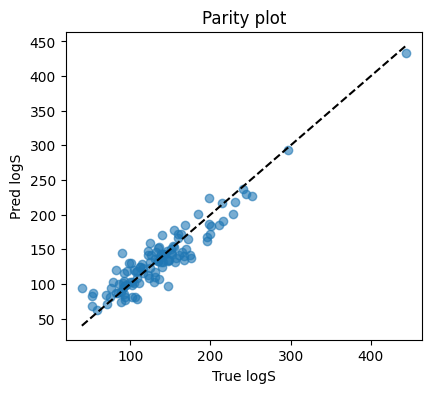

In [11]:
reg_model2.eval()
with torch.no_grad():
    yhat_te = reg_model2(torch.from_numpy(X_te_s)).cpu().numpy()

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_te, yhat_te))
print("R2:", r2_score(y_te, yhat_te))

plt.figure(figsize=(4.6,4))
plt.scatter(y_te, yhat_te, alpha=0.6)
lims = [min(y_te.min(), yhat_te.min()), max(y_te.max(), yhat_te.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Pred logS")
plt.title("Parity plot")
plt.show()

This suggests our customized NN achieve a good performance on this task  :D


## 2.7 Baseline comparison

To understand how our PyTorch neural network compares to standard regressors, 
we evaluate three baselines:

- **Decision Tree Regressor**: a single non-linear tree.
- **Random Forest Regressor**: an ensemble of decision trees.
- **MLPRegressor (sklearn)**: configured to closely match our PyTorch NN.

Our PyTorch model is:  
- Input: 4 features  
- Hidden layer: 32 units with ReLU  
- Output: 1 unit  
- Optimizer: Adam with learning rate 1e-2 and weight decay 1e-3  
- Trained for 150 epochs with mini-batches of size 64.

To mirror this in `scikit-learn`, we set:

- `hidden_layer_sizes=(32,)`: one hidden layer of 32 units, just like PyTorch.  
- `activation="relu"`: same nonlinearity.  
- `solver="adam"`: same optimization family.  
- `learning_rate_init=1e-2`: match the PyTorch learning rate.  
- `alpha=1e-3`: equivalent to weight decay 1e-3.  
- `max_iter=2000`: roughly comparable to 150 epochs in Torch.


We then compare all four models (Decision Tree, Random Forest, sklearn MLP, and PyTorch NN) 
on the test set using **MSE** and **R²**.  



```{admonition} ⏰ Exercises 2.x
1) For our own NN by Pytorch change the hidden size to 64 and rerun. Does R² improve.  
2) Increase `weight_decay` to `1e-2`. What happens to train vs test scores.  

> You need to re-initialize the optimizer and re-run the training loop, as there is no `.fit(...)` function for our customized NN. In next section you will see we can wrap this
logic into a helper function to avoid repetition.
```
### 2.8 PyTorch Regressor with sklearn-like Interface

In earlier sections, we trained our custom PyTorch model by manually writing the
training loop. How can we make our customized NN feel more convenient? 

We can introduce a small wrapper called **`CHEM5080Regressor`** that makes our
PyTorch model behave like a sklearn regressor. The class builds a Sequential
network with two hidden layers (64 units with ReLU, then 32 units with Tanh),
and provides:

- `.fit(X, y)` for training
- `.predict(X)` for inference

This way, the PyTorch model can be plugged into the same workflow as Decision
Tree, Random Forest, or sklearn’s MLP. You can customize the architecture inside
`nn.Sequential` by changing the hidden sizes or swapping the activation
functions.

In [12]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class CHEM5080Regressor:
    """
    A simple sklearn-like wrapper around a PyTorch feed-forward regressor.
    Architecture:
        Input -> Linear(4, 64) -> ReLU
              -> Linear(64, 32) -> ReLU
              -> Linear(32, 1)
    """
    def __init__(self, in_dim, lr=1e-2, weight_decay=1e-3, epochs=150, batch_size=64):
        # Build Sequential model
        self.model = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),         # Hidden layer 1
            nn.Linear(64, 32),
            nn.ReLU(),         # Hidden layer 2
            nn.Linear(32, 1)   # Output
        )
        # Training settings
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def fit(self, X, y):
        dataset = NumpyDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float()
            return self.model(X_tensor).cpu().numpy().ravel()

# --- Train and evaluate ---
chem_model = CHEM5080Regressor(in_dim=X_tr_s.shape[1], epochs=150)
chem_model.fit(X_tr_s, y_tr)
y_pred = chem_model.predict(X_te_s)

print("MSE:", mean_squared_error(y_te, y_pred))
print("R2:", r2_score(y_te, y_pred))


MSE: 387.48224
R2: 0.8697618698517982


It works exactly the same way as we see in previous lectures with `sklearn`, but it was **written by ourselves**!

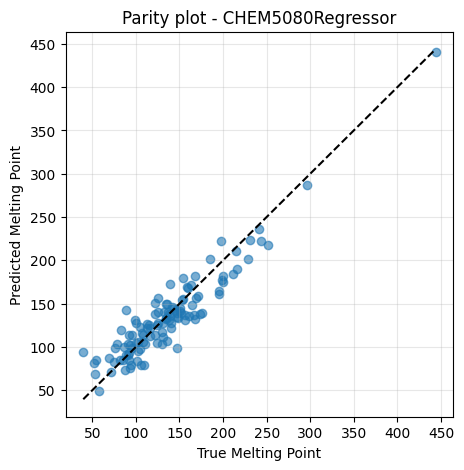

In [13]:
# --- Optional: Parity plot ---
plt.figure(figsize=(5,5))
plt.scatter(y_te, y_pred, alpha=0.6)
lims = [min(y_te.min(), y_pred.min()), max(y_te.max(), y_pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True Melting Point")
plt.ylabel("Predicted Melting Point")
plt.title("Parity plot - CHEM5080Regressor")
plt.grid(alpha=0.3)
plt.show()

---

## 3) Molecules as graphs

A molecule can be seen as a graph:  
- **Nodes** are atoms with a feature vector per atom.  
- **Edges** are bonds that carry types such as single, double, aromatic.  
- A molecule level label (melting point, toxicity) requires **pooling** node representations into one vector.

### 3.1 Minimal node and edge features

Common node features:
- One‑hot element type, degree, formal charge, aromatic flag.  
Common edge features:
- Bond type one‑hot: single, double, triple, aromatic.

We will assemble a small structure that holds:
- `x`: node feature matrix, shape `[n_nodes, d_node]`  
- `edge_index`: list of edges as two rows `[2, n_edges]`  
- `edge_attr`: edge features `[n_edges, d_edge]` (optional)  
- `y`: target for the graph

### 3.2 Build tiny toy graphs by hand

We start with two toy molecules without RDKit: Methane and Ethane.

In [14]:
def toy_methane():
    # C with 4 H; simple graph centered on C
    # nodes: 0=C, 1..4=H
    x = np.array([
        [6, 4, 0, 0],  # very small features: [atomic_number, degree, is_aromatic, formal_charge]
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
    ], dtype=np.float32)
    edges = []
    for h in [1,2,3,4]:
        edges += [(0, h), (h, 0)]
    edge_index = np.array(edges, dtype=np.int64).T  # shape [2, 8]
    return {"x": x, "edge_index": edge_index}

def toy_ethane():
    # C-C with 3 H on each carbon
    x = np.array([
        [6, 4, 0, 0], [6, 4, 0, 0],  # two carbons
        [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0],  # Hs on C0
        [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0],  # Hs on C1
    ], dtype=np.float32)
    edges = [(0,1),(1,0)]
    for h in [2,3,4]: edges += [(0,h),(h,0)]
    for h in [5,6,7]: edges += [(1,h),(h,1)]
    edge_index = np.array(edges, dtype=np.int64).T
    return {"x": x, "edge_index": edge_index}

g1, g2 = toy_methane(), toy_ethane()
[g1["x"].shape, g1["edge_index"].shape, g2["x"].shape, g2["edge_index"].shape]

[(5, 4), (2, 8), (8, 4), (2, 14)]

Peek at arrays to make sure the shapes are what you expect.

In [15]:
print("Methane x:\n", g1["x"])
print("Methane edges (first 6 cols):\n", g1["edge_index"][:, :6])

Methane x:
 [[6. 4. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
Methane edges (first 6 cols):
 [[0 1 0 2 0 3]
 [1 0 2 0 3 0]]


```{admonition} Tip
Large SMILES → RDKit graphs come later. For now the goal is to **see** the shapes and write a message passing layer on these toy graphs.
```

```{admonition} ⏰ Exercises 3.x
Add a new toy graph for **propane** with indices `[0,1,2]` as the carbon chain and correct hydrogens. Return the same keys `x` and `edge_index`. Print its shapes.
```

---

## 4) Message passing: the core idea

At each layer `t`, every node gets messages from its neighbors and updates its hidden state.

A simple form:

$$
h_v^{(t+1)} = \sigma\left(W_\text{self}\, h_v^{(t)} + \sum_{u \in \mathcal{N}(v)} W_\text{nei}\, h_u^{(t)} + b\right)
$$

- `h_v^{(t)}` is the node vector at layer `t`.  
- `W_self` maps the node to itself.  
- `W_nei` maps neighbor messages.  
- Sum neighbor messages, then apply a nonlinearity `σ` such as ReLU.

After `T` layers, pool all node vectors to get a graph vector:

$$
h_\text{graph} = \text{POOL}\left(\{h_v^{(T)} : v \in \text{nodes}\}\right)
$$

POOL can be **sum**, **mean**, or **max**. For regression we feed `h_graph` to a linear head to predict a scalar.

---

## 5) Your first GNN layer in pure PyTorch

We implement a very small GNN layer that follows the equation above. No external graph library is needed.

### 5.1 A neighbor sum helper

In [16]:
def neighbor_sum(x, edge_index):
    """
    x: [N, d] node features
    edge_index: [2, E] with rows [src, dst]
    returns: [N, d] sum of neighbor features for each node (incoming edges)
    """
    N, d = x.shape
    out = torch.zeros_like(x)
    src, dst = edge_index
    out.index_add_(0, dst, x[src])  # sum x[src] into row dst
    return out

### 5.2 Define one message passing layer

In [17]:
class SimpleMP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.self_lin = nn.Linear(in_dim, out_dim, bias=True)
        self.nei_lin  = nn.Linear(in_dim, out_dim, bias=False)
        self.act = nn.ReLU()

    def forward(self, x, edge_index):
        # x: [N, in_dim], edge_index: tensor [2, E]
        nei_agg = neighbor_sum(x, edge_index)           # [N, in_dim]
        out = self.self_lin(x) + self.nei_lin(nei_agg)  # [N, out_dim]
        return self.act(out)

### 5.3 Stack layers and pool to a graph vector

In [18]:
class TinyGNN(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, num_layers=2, pool="mean"):
        super().__init__()
        layers = []
        dim = in_dim
        for _ in range(num_layers):
            layers.append(SimpleMP(dim, hidden))
            dim = hidden
        self.layers = nn.ModuleList(layers)
        self.head = nn.Linear(hidden, out_dim)
        self.pool = pool

    def readout(self, x):
        if self.pool == "sum":  return x.sum(dim=0, keepdim=True)
        if self.pool == "max":  return x.max(dim=0, keepdim=True).values
        return x.mean(dim=0, keepdim=True)  # default mean

    def forward(self, x, edge_index):
        for mp in self.layers:
            x = mp(x, edge_index)
        hg = self.readout(x)         # [1, hidden]
        y = self.head(hg)            # [1, out_dim]
        return y  # graph-level output

### 5.4 Sanity check with toy graphs

We will make up fake targets for the toys to see the forward pass shape.

In [19]:
def to_tensor_graph(g):
    x = torch.from_numpy(g["x"])
    edge_index = torch.from_numpy(g["edge_index"])
    return x, edge_index

x1, e1 = to_tensor_graph(g1)
x2, e2 = to_tensor_graph(g2)

gnn = TinyGNN(in_dim=x1.shape[1], hidden=16, out_dim=1, num_layers=2, pool="mean")
with torch.no_grad():
    y1 = gnn(x1, e1)
    y2 = gnn(x2, e2)
print("Toy outputs:", y1.shape, y2.shape)

Toy outputs: torch.Size([1, 1]) torch.Size([1, 1])


### 5.5 Train on toy data (regression on a made‑up scalar)

Let us define a toy label such as “number of heavy atoms”. This is only for demonstration.

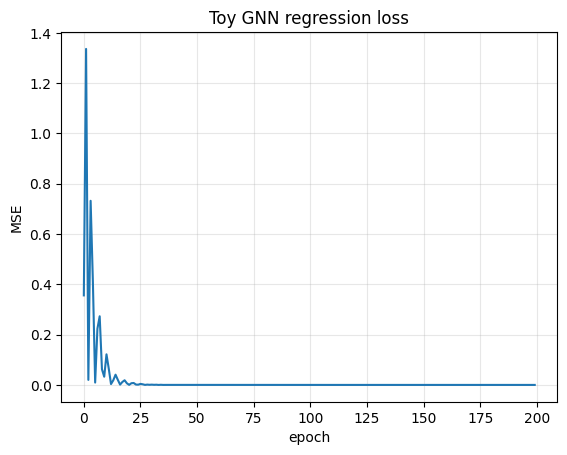

pred 1.0 target 1.0
pred 2.0 target 2.0


In [20]:
def heavy_atom_count(g):
    # heavy atoms = atomic_number > 1
    return float((g["x"][:,0] > 1).sum())

train_graphs = [toy_methane(), toy_ethane()]
y_train = torch.tensor([[heavy_atom_count(g)] for g in train_graphs], dtype=torch.float32)

gnn = TinyGNN(in_dim=train_graphs[0]["x"].shape[1], hidden=16, out_dim=1, num_layers=2, pool="sum")
opt = torch.optim.Adam(gnn.parameters(), lr=5e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

losses = []
for epoch in range(200):
    epoch_loss = 0.0
    for g, ytrue in zip(train_graphs, y_train):
        x, ei = to_tensor_graph(g)
        pred = gnn(x, ei)
        loss = loss_fn(pred, ytrue.view(1,1))
        opt.zero_grad(); loss.backward(); opt.step()
        epoch_loss += float(loss.item())
    losses.append(epoch_loss/len(train_graphs))

plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Toy GNN regression loss")
plt.grid(alpha=0.3); plt.show()

for g in train_graphs:
    with torch.no_grad():
        p = gnn(*to_tensor_graph(g)).item()
    print("pred", round(p,3), "target", heavy_atom_count(g))

```{admonition} What you saw
- Node vectors flowed through two message passing layers.  
- A readout pooled node states to a graph vector.  
- A tiny head predicted a scalar.  
```

```{admonition} ⏰ Exercises 5.x
1) Switch pooling from `"sum"` to `"mean"` and retrain. Compare convergence.  
2) Replace `ReLU` with `Tanh` inside `SimpleMP`. Does the curve change.  
3) Change the target to “number of hydrogens” and retrain.  
```

---

## 6) From SMILES to graphs with RDKit (mini pipeline)

Now we prepare graphs from real SMILES. If RDKit is not available in your environment, skip to Section 7 (Chemprop), which does not require RDKit.

### 6.1 Featurization helpers

In [21]:
def atom_features(atom):
    # one short vector per atom; keep it tiny for speed
    return np.array([
        atom.GetAtomicNum(),                 # Z
        atom.GetTotalDegree(),               # degree
        int(atom.GetIsAromatic()),           # aromatic
        atom.GetFormalCharge()               # charge
    ], dtype=np.float32)

def bond_pairs(mol):
    src, dst = [], []
    for b in mol.GetBonds():
        a = b.GetBeginAtomIdx()
        c = b.GetEndAtomIdx()
        src += [a, c]
        dst += [c, a]
    return np.array([src, dst], dtype=np.int64)

def smiles_to_graph(smi):
    if Chem is None:
        raise RuntimeError("RDKit not available. Please skip to Section 7 (Chemprop).")
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return None
    x = np.vstack([atom_features(a) for a in mol.GetAtoms()])  # [N,d]
    ei = bond_pairs(mol)                                       # [2,E]
    return {"x": x, "edge_index": ei}

### 6.2 Make a small dataset from the CSV

We will try to regress **melting point** as a quick demo with the tiny GNN. This is only to show the flow; Chemprop will do a stronger job later.

In [22]:
if Chem is not None:
    small = df_raw[["SMILES","Melting Point"]].dropna().sample(200, random_state=0)
    graphs, targets = [], []
    for smi, mp in zip(small["SMILES"], small["Melting Point"]):
        g = smiles_to_graph(smi)
        if g is not None:
            graphs.append(g); targets.append(mp)
    y_all = torch.tensor(targets, dtype=torch.float32).view(-1,1)
    len(graphs), y_all.shape
else:
    print("RDKit missing. Skip to Section 7.")

NameError: name 'df_raw' is not defined

### 6.3 Tiny training loop for graphs

We split by index since graphs are already constructed.

In [ ]:
if Chem is not None and len(graphs) > 20:
    idx = np.arange(len(graphs))
    tr_idx, te_idx = train_test_split(idx, test_size=0.2, random_state=42)
    gnn = TinyGNN(in_dim=graphs[0]["x"].shape[1], hidden=32, out_dim=1, num_layers=3, pool="mean")
    opt = torch.optim.Adam(gnn.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    losses = []
    for epoch in range(60):
        batch = np.random.choice(tr_idx, size=min(64, len(tr_idx)), replace=False)
        epoch_loss = 0.0
        for i in batch:
            x = torch.from_numpy(graphs[i]["x"])
            ei = torch.from_numpy(graphs[i]["edge_index"])
            pred = gnn(x, ei)
            loss = loss_fn(pred, y_all[i:i+1])
            opt.zero_grad(); loss.backward(); opt.step()
            epoch_loss += float(loss.item())
        losses.append(epoch_loss/len(batch))

    plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Tiny GNN on melting point")
    plt.grid(alpha=0.3); plt.show()

    # Evaluate
    y_true, y_pred = [], []
    gnn.eval()
    with torch.no_grad():
        for i in te_idx:
            p = gnn(torch.from_numpy(graphs[i]["x"]),
                    torch.from_numpy(graphs[i]["edge_index"])).item()
            y_true.append(float(y_all[i]))
            y_pred.append(p)

    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R2 : {r2_score(y_true, y_pred):.3f}")

    plt.scatter(y_true, y_pred, alpha=0.6)
    lims = [min(min(y_true), min(y_pred)), max(max(y_true), max(y_pred))]
    plt.plot(lims, lims, "k--"); plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Tiny GNN parity")
    plt.show()

```{admonition} Takeaway
This simple GNN is **minimal**. Real molecular GNNs use richer atom and bond features, multiple heads, dropout, and careful training schedules.
```

```{admonition} ⏰ Exercises 6.x
1) Change `num_layers` from 3 to 2 and 4. Record test R² for each.  
2) Change pooling from mean to sum. Does performance change.  
3) Add `nn.Dropout(p=0.1)` after each `SimpleMP` in `TinyGNN` and test again.  
```

---

## 7) Chemprop v2: practical graph models for chemistry

Chemprop implements a directed message passing neural network with strong defaults. We will:

1) **Install Chemprop v2**  
2) Run a **melting point** regression  
3) Run a **reactivity** classification and predict on new SMILES

### 7.1 Install Chemprop

In [ ]:
# You may need a restart after install in some environments
%pip -q install chemprop

### 7.2 Melting point regression

Prepare a minimal CSV: `SMILES,Melting Point`.

In [ ]:
# Load data and write a small CSV
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df = pd.read_csv(url)
reg_cols = ["SMILES", "Melting Point"]
df_reg = df[reg_cols].dropna().copy()
df_reg.head(3)

Save to disk for Chemprop CLI.

In [ ]:
df_reg.to_csv("mp_data.csv", index=False)
len(df_reg), df_reg.head(2)

Train a **small** model so it runs in class. We log common metrics.

In [ ]:
# A short run. Increase epochs later if you have time/GPU.
!chemprop train \
  --data-path mp_data.csv \
  -t regression \
  -s SMILES \
  --target-columns "Melting Point" \
  -o mp_model \
  --num-replicates 1 \
  --epochs 15 \
  --save-smiles-splits \
  --metrics mae rmse r2 \
  --tracking-metric r2

Make quick predictions on a few molecules.

In [ ]:
smiles_list = [
    "CCO",              # ethanol
    "c1ccccc1",         # benzene
    "CC(=O)O",          # acetic acid
    "CCN(CC)CC"         # triethylamine
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles_reg.csv", index=False)

!chemprop predict \
  --test-path custom_smiles_reg.csv \
  --model-paths mp_model/replicate_0/model_0/best.pt \
  --preds-path mp_preds.csv

pd.read_csv("mp_preds.csv")

### 7.3 Reactivity classification (C–H oxidation dataset)

We use the `Reactivity` column and convert it to **binary** 0/1.

In [ ]:
df = pd.read_csv(url)
df["Reactivity_bin"] = df["Reactivity"].replace({-1: 0}).astype(int)
df[["SMILES","Reactivity","Reactivity_bin"]].head(3)

Write a minimal file.

In [ ]:
df[["SMILES", "Reactivity_bin"]].to_csv("reactivity_data_bin.csv", index=False)

# Optional: sanity check the class balance
print(df["Reactivity"].value_counts(dropna=False).to_dict())
print(df["Reactivity_bin"].value_counts(dropna=False).to_dict())

Train a short classification model.

In [ ]:
!chemprop train \
  --data-path reactivity_data_bin.csv \
  -t classification \
  -s SMILES \
  --target-columns Reactivity_bin \
  -o reactivity_model \
  --num-replicates 1 \
  --epochs 15 \
  --class-balance \
  --metrics roc prc accuracy \
  --tracking-metric roc

Predict on new SMILES.

In [ ]:
smiles_list = [
    "CCO",
    "c1ccccc1C(F)",
    "C1=C([C@@H]2C[C@H](C1)C2(C)C)",
    "C1=CC=CC=C1C=O",
    "CCN(CC)CC",
    "c1cccc(C=CC)c1"
]
pd.DataFrame({"SMILES": smiles_list}).to_csv("custom_smiles.csv", index=False)

!chemprop predict \
  --test-path custom_smiles.csv \
  --model-paths reactivity_model/replicate_0/model_0/best.pt \
  --preds-path custom_preds.csv

pd.read_csv("custom_preds.csv")

```{admonition} Tips
- Increase `--num-replicates` to 3 and `--epochs` to 50-100 for stronger baselines.  
- For class imbalance, keep `--class-balance`.  
- Use `--save-smiles-splits` to capture exact train/val/test molecules for reproducibility.  
```

```{admonition} ⏰ Exercises 7.x
1) Add `--ensemble-size 5` during prediction by passing multiple `--model-paths` if you trained replicates. Compare ROC.  
2) Change tracking metric to `prc` and rerun. Does validation selection change.  
3) For melting point, add `--ffn-hidden-size 800` to increase the head capacity and try 30 epochs.  
```

---

## 8) References

- Gilmer, J. et al., **Neural Message Passing for Quantum Chemistry**, ICML 2017.  
- Yang, K. et al., **Analyzing Learned Molecular Representations for Property Prediction**, J. Chem. Inf. Model. 2019.  
- Chemprop documentation: training flags, metrics, and examples.  
- RDKit: molecule objects, atom and bond APIs.  
- PyTorch: custom `nn.Module`, autograd, and optimizers.

*(If you need links, see your course page where these are listed with URLs.)*

---

## 9) Glossary

```{glossary}
graph neural network
  A neural model that updates node states by aggregating messages from neighbors.

message passing
  The update step where a node combines its own vector with aggregated neighbor vectors.

readout (pooling)
  Operation that compresses node states into a single graph vector, often by sum, mean, or max.

edge index
  A 2×E tensor listing source and destination of each edge.

Chemprop
  A practical library that trains message passing networks directly from SMILES.

replicate
  Independent training run with a different random seed. Often ensembled for stability.

tracking metric
  The metric used to pick the best checkpoint during training.

class balance
  Loss weighting that compensates for skewed class proportions.
```

---

## 10) In‑class activity and solutions

Each question is designed to be solved with what you coded above. Try first, then check the solution blocks.

### Q1. MLP warmup on melting point

- Use features `[MolWt, LogP, TPSA, NumRings]`  
- Standardize, then train the PyTorch MLP `(32,)` for 150 epochs  
- Report `MSE`, `MAE`, `R²` and draw a parity plot

```python
# TO DO: write your MLP training in PyTorch as in Section 2
```

---

### Q2. Build and inspect the toy GNN

- Train `TinyGNN` with pooling `"sum"` on methane and ethane to predict **heavy atom count**  
- Plot the loss  
- Change pooling to `"mean"` and compare loss and predictions

```python
# TO DO: reuse the code in Section 5
```

---

### Q3. RDKit graph mini‑set (optional if RDKit missing)

- Sample 200 SMILES with melting points from the CSV  
- Convert to graphs and train `TinyGNN` with `num_layers=3`, hidden 32  
- Report `R²` on a 80/20 split and draw a parity plot

```python
# TO DO: follow Section 6
```

---

### Q4. Chemprop regression on melting point

- Train Chemprop on `mp_data.csv` for `--epochs 20`  
- Predict on at least 5 new SMILES of your choice and list the predictions

```python
# TO DO: run the chemprop CLI as in Section 7.2
```

---

### Q5. Chemprop classification on toxicity 

- Convert `Toxicity` to `1/0` using the mapping `{toxic:1, non_toxic:0}`  
- Save `["SMILES","Toxicity_bin"]` to `tox_data.csv`  
- Train with `--class-balance --epochs 20` and metrics `roc prc accuracy`  
- Predict on a small set of SMILES; show the class probability

```python
# TO DO: similar to Section 7.3, but target is Toxicity_bin
```

---

### Solutions

#### Solution Q1

In [ ]:
# Q1 solution
set_seed(0)
df_reg = df_raw[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)
y = df_reg["Melting Point"].values.astype(np.float32).reshape(-1,1)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
sc = StandardScaler().fit(Xtr)
Xtr_s = sc.transform(Xtr).astype(np.float32)
Xte_s = sc.transform(Xte).astype(np.float32)

mlp = TinyMLP(in_dim=4, hidden=32, out_dim=1)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-3)
train_loader = DataLoader(NumpyDataset(Xtr_s, ytr), batch_size=64, shuffle=True)

losses = []
for epoch in range(150):
    bs = []
    for xb, yb in train_loader:
        pred = mlp(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        bs.append(loss.item())
    losses.append(np.mean(bs))

mlp.eval()
with torch.no_grad():
    yhat = mlp(torch.from_numpy(Xte_s)).numpy()

print(f"MSE={mean_squared_error(yte, yhat):.2f}  MAE={mean_absolute_error(yte, yhat):.2f}  R2={r2_score(yte, yhat):.3f}")
plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Q1 MLP loss"); plt.grid(alpha=0.3); plt.show()

plt.scatter(yte, yhat, alpha=0.6)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--"); plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Q1 parity")
plt.show()

#### Solution Q2

In [ ]:
# Q2 solution
train_graphs = [toy_methane(), toy_ethane()]
y_train = torch.tensor([[heavy_atom_count(g)] for g in train_graphs], dtype=torch.float32)

def run(pool):
    gnn = TinyGNN(in_dim=train_graphs[0]["x"].shape[1], hidden=16, out_dim=1, num_layers=2, pool=pool)
    opt = torch.optim.Adam(gnn.parameters(), lr=5e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(200):
        s = 0.0
        for g, ytrue in zip(train_graphs, y_train):
            x = torch.from_numpy(g["x"]); ei = torch.from_numpy(g["edge_index"])
            pred = gnn(x, ei); loss = loss_fn(pred, ytrue.view(1,1))
            opt.zero_grad(); loss.backward(); opt.step(); s += loss.item()
        losses.append(s/len(train_graphs))
    return gnn, losses

g_sum, L_sum = run("sum")
g_mean, L_mean = run("mean")

plt.plot(L_sum, label="sum"); plt.plot(L_mean, label="mean")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Q2 loss"); plt.legend(); plt.grid(alpha=0.3); plt.show()

for tag, gnn in [("sum", g_sum), ("mean", g_mean)]:
    for g in train_graphs:
        with torch.no_grad():
            p = gnn(torch.from_numpy(g["x"]), torch.from_numpy(g["edge_index"])).item()
        print(tag, "pred", round(p,3), "target", heavy_atom_count(g))

#### Solution Q3

In [ ]:
# Q3 solution (skip if RDKit missing)
if Chem is not None:
    small = df_raw[["SMILES","Melting Point"]].dropna().sample(200, random_state=0)
    graphs, y = [], []
    for smi, mp in zip(small["SMILES"], small["Melting Point"]):
        g = smiles_to_graph(smi)
        if g is not None:
            graphs.append(g); y.append(mp)
    y = torch.tensor(y, dtype=torch.float32).view(-1,1)

    idx = np.arange(len(graphs))
    tr, te = train_test_split(idx, test_size=0.2, random_state=42)
    gnn = TinyGNN(in_dim=graphs[0]["x"].shape[1], hidden=32, out_dim=1, num_layers=3, pool="mean")
    opt = torch.optim.Adam(gnn.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    for epoch in range(60):
        batch = np.random.choice(tr, size=min(64, len(tr)), replace=False)
        for i in batch:
            x = torch.from_numpy(graphs[i]["x"])
            ei = torch.from_numpy(graphs[i]["edge_index"])
            pred = gnn(x, ei); loss = loss_fn(pred, y[i:i+1])
            opt.zero_grad(); opt.step()

    yt, yp = [], []
    gnn.eval()
    with torch.no_grad():
        for i in te:
            yp.append(gnn(torch.from_numpy(graphs[i]["x"]),
                          torch.from_numpy(graphs[i]["edge_index"])).item())
            yt.append(float(y[i]))

    from sklearn.metrics import mean_absolute_error, r2_score
    print(f"R2: {r2_score(yt, yp):.3f}  MAE: {mean_absolute_error(yt, yp):.2f}")
else:
    print("RDKit missing; skip Q3.")

#### Solution Q4

In [ ]:
# Q4 solution
df_reg = df[["SMILES","Melting Point"]].dropna().copy()
df_reg.to_csv("mp_data.csv", index=False)

!chemprop train \
  --data-path mp_data.csv \
  -t regression \
  -s SMILES \
  --target-columns "Melting Point" \
  -o mp_model_q4 \
  --num-replicates 1 \
  --epochs 20 \
  --metrics mae rmse r2 \
  --tracking-metric r2

pd.DataFrame({"SMILES": ["CCO","c1ccccc1","CC(=O)O","CCN(CC)CC","O=C(O)C(O)C"]}).to_csv("q4_smiles.csv", index=False)

!chemprop predict \
  --test-path q4_smiles.csv \
  --model-paths mp_model_q4/replicate_0/model_0/best.pt \
  --preds-path q4_preds.csv

pd.read_csv("q4_preds.csv")

#### Solution Q5

In [ ]:
# Q5 solution
df = pd.read_csv(url)
df = df[["SMILES","Toxicity"]].dropna().copy()
df["Toxicity_bin"] = df["Toxicity"].str.lower().map({"toxic":1, "non_toxic":0}).astype(int)
df[["SMILES","Toxicity_bin"]].to_csv("tox_data.csv", index=False)

!chemprop train \
  --data-path tox_data.csv \
  -t classification \
  -s SMILES \
  --target-columns Toxicity_bin \
  -o tox_model \
  --num-replicates 1 \
  --epochs 20 \
  --class-balance \
  --metrics roc prc accuracy \
  --tracking-metric roc

pd.DataFrame({"SMILES": ["CCO","c1ccccc1","O=[N+](=O)[O-]","ClCCl","CC(=O)Cl"]}).to_csv("q5_smiles.csv", index=False)

!chemprop predict \
  --test-path q5_smiles.csv \
  --model-paths tox_model/replicate_0/model_0/best.pt \
  --preds-path q5_preds.csv

pd.read_csv("q5_preds.csv")

---

### Quick cheat sheet

- Message passing layer shape checks help catch indexing mistakes early.  
- Pooling choice can change gradients a lot on small graphs.  
- Chemprop is fast to try. Start with 15–30 epochs and 1–3 replicates during class. Increase later.  
- For classification targets, always look at `roc` and `prc`, not only accuracy.  

---

```{admonition} What to remember
- An MLP ignores graph structure. A GNN uses edges to mix neighbor information.  
- The core update is neighbor aggregation followed by a learnable transformation.  
- Chemprop encodes many best practices so you can focus on data and targets.  
```

```{admonition} Where this connects
Back to Lecture 8: you built MLPs and read loss curves. The same training loop ideas apply to GNNs. The difference is the **forward** pass uses a graph structure to route information.
```

```{admonition} Try at home
- Compare `sum` vs `mean` pooling on size‑varying molecules.  
- Add bond type one‑hot to the neighbor message with a small MLP inside `SimpleMP`.  
- Use Chemprop for **logS** regression and compare to your MLP from Lecture 8.  
```